In [54]:
%pip install kneed

In [55]:
import pandas as pd
csv_file_path = 'elbow_avg_output_sample2.csv'
data = pd.read_csv(csv_file_path, header=0)
print(data)
csv_file_path = 'init_input.csv'
sentences = pd.read_csv(csv_file_path, header=0)
print(sentences)

    0  1        2         3         4
0   0  2  Persian  0.006421  0.007812
1   1  2  Persian  0.006421  0.007812
2   2  3  Persian  0.007791  0.007812
3   3  1  Persian  0.006378  0.007812
4   4  1  Persian  0.008785  0.007812
.. .. ..      ...       ...       ...
79  1  2    Dutch  0.004344  0.054688
80  2  3    Dutch  0.005148  0.054688
81  3  1    Dutch  0.004037  0.054688
82  4  1    Dutch  0.004732  0.054688
83  5  3    Dutch  0.005157  0.054688

[84 rows x 5 columns]
   ID  Type                                             Source
0   0     2  Andrei and Danny picked up the yellow chair an...
1   1     2   Andrei looked at Danny putting down a yellow bag
2   2     3             Andrei approached Danny; he held a bag
3   3     1              Andrei and Danny moved a yellow chair
4   4     1                     Yevgeni left Andrei; Danny too
5   5     3  Danny put down the bag and the chair; it was g...


[['0' '2' 'Persian' '0.015625' '0.0060321153']
 ['0' '2' 'Dutch' '0.03125' '0.004296152']
 ['1' '2' 'Persian' '0.0390625' '0.0053855306']
 ['1' '2' 'Dutch' '0.0078125' '0.0052953097']
 ['2' '3' 'Persian' '0.0234375' '0.006943506']
 ['2' '3' 'Dutch' '0.0078125' '0.006138668']
 ['3' '1' 'Persian' '0.0234375' '0.0055354615']
 ['3' '1' 'Dutch' '0.03125' '0.004183575']
 ['4' '1' 'Persian' '0.03125' '0.007027046']
 ['4' '1' 'Dutch' '0.0390625' '0.004977315']
 ['5' '3' 'Persian' '0.015625' '0.00707549']
 ['5' '3' 'Dutch' '0.0234375' '0.0054792664']]


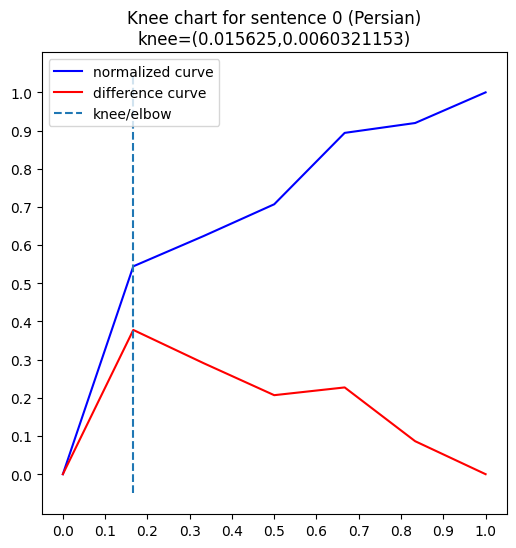

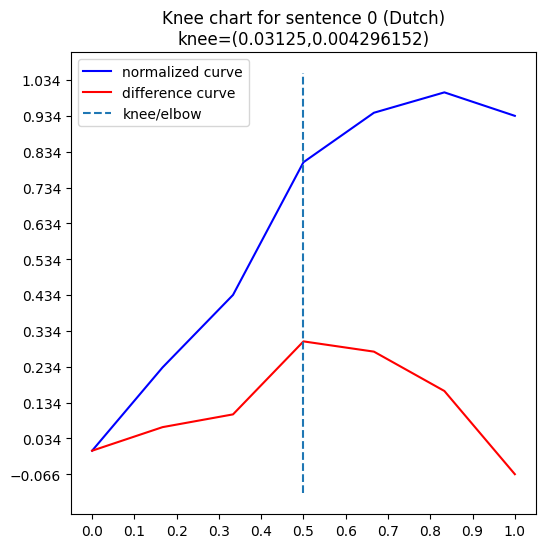

In [56]:
import kneed
import numpy as np
import matplotlib.pyplot as plt

results = np.empty((0, 5))
for id in data['0'].unique():
    for lang in data['2'].unique():
      filter = data[(data['0']==id) & (data['2']==lang)]
      t = filter['1'].unique()[0]
      e = filter['3']
      c = filter['4']
      kneedle = kneed.KneeLocator(c, e, S=1.0, curve="convex", direction="decreasing")
      x = kneedle.knee
      y = kneedle.knee_y
      new_row = np.array([id, t, lang, x, y])
      results = np.append(results, [new_row], axis=0)

      if id == 0:
        if True: #lang == 'Persian':
          kneedle.plot_knee_normalized(title='Knee chart for sentence %s (%s)\nknee=(%s,%s)' % (id, lang, x, y))
          plt.savefig('knee_%s_%s.png' % (id, lang))
print(results)

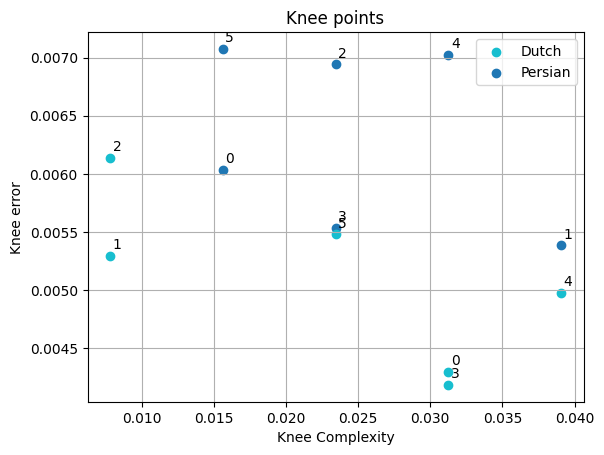

In [57]:
import pandas as pd
import matplotlib.colors as mcolors

df = pd.DataFrame(results)
df[0] = df[0].astype(int)
df[1] = df[1].astype(int)
df[2] = df[2].astype(str)
df[3] = df[3].astype(float)
df[4] = df[4].astype(float)

# Get unique categories
unique_categories = np.unique(df[2].unique())
num_categories = len(unique_categories)

# Define a colormap with enough distinct colors
cmap = plt.get_cmap('tab10', num_categories)
norm = mcolors.Normalize(vmin=0, vmax=num_categories - 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

scatter_plots = {}
for i, lang in enumerate(df[2].unique()):
    df2 = df[(df[2] == lang)]
    data = {'X': df2[3].values,
            'Y': df2[4].values}
    df2 = pd.DataFrame(data)
    scatter_plots[lang] = plt.scatter(df2['X'], df2['Y'], marker='o', color=cmap(i), label=lang)
for i, label in enumerate(df[0]):
    plt.annotate(label, (df[3][i], df[4][i]), textcoords="offset points",
                 xytext=(5,5), ha='center')
plt.xlabel('Knee Complexity')
plt.ylabel('Knee error')
plt.title('Knee points')
plt.legend(handles=[scatter_plots[cat] for cat in unique_categories])
plt.grid(True)
plt.savefig('knee_scatter.png')
plt.show()

In [58]:
df[5] = np.sqrt((1-df[3]) * (1-df[4]))
print(df)

    0  1        2         3         4         5
0   0  2  Persian  0.015625  0.006032  0.989160
1   0  2    Dutch  0.031250  0.004296  0.982134
2   1  2  Persian  0.039062  0.005386  0.977631
3   1  2    Dutch  0.007812  0.005295  0.993445
4   2  3  Persian  0.023438  0.006944  0.984775
5   2  3    Dutch  0.007812  0.006139  0.993024
6   3  1  Persian  0.023438  0.005535  0.985473
7   3  1    Dutch  0.031250  0.004184  0.982190
8   4  1  Persian  0.031250  0.007027  0.980787
9   4  1    Dutch  0.039062  0.004977  0.977832
10  5  3  Persian  0.015625  0.007075  0.988641
11  5  3    Dutch  0.023438  0.005479  0.985501


In [59]:
alphas = np.empty((0,5))
for id in df[0].unique():
  filter = df[df[0]==id]
  filter[6]=2*np.abs(filter[5]-0.5)
  filter = filter.reset_index(drop=True)
  n=len(filter[2].unique())
  mx = np.empty((n,n))
  for i in range(n):
    for j in range(n):
      mx[i,j]=np.abs(filter[5][i]-filter[5][j])
  term1 = 1 - np.sum(filter[6]) / n
  term2 = np.sum(mx) / (n**2)
  alpha = 0.5 * term1 + 0.5 * term2
  alphas = np.vstack((alphas, [id, filter[1][0], term1, term2, alpha]))
df_alphas = pd.DataFrame(alphas)
df_alphas[0] = df_alphas[0].astype(int)
df_alphas[1] = df_alphas[1].astype(int)
df_alphas[2] = df_alphas[2].astype(float)
df_alphas[3] = df_alphas[3].astype(float)
df_alphas[4] = df_alphas[4].astype(float)

<ipython-input-59-43e731bf49fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter[6]=2*np.abs(filter[5]-0.5)


In [61]:
merged_df = pd.merge(df_alphas, sentences, left_on=0, right_on='ID')
merged_df = merged_df.loc[:,[0,1,2,3,4,'Source']]
merged_df.columns = ['ID', 'type', 'term1', 'term2', 'alpha', 'sentence']
print(merged_df)
merged_df.to_csv('alphas_avg_output_sample2.csv', index=False)

   ID  type     term1     term2     alpha  \
0   0     2  0.028706  0.003513  0.016109   
1   1     2  0.028924  0.007907  0.018415   
2   2     3  0.022201  0.004125  0.013163   
3   3     1  0.032337  0.001641  0.016989   
4   4     1  0.041382  0.001478  0.021430   
5   5     3  0.025859  0.001570  0.013714   

                                            sentence  
0  Andrei and Danny picked up the yellow chair an...  
1   Andrei looked at Danny putting down a yellow bag  
2             Andrei approached Danny; he held a bag  
3              Andrei and Danny moved a yellow chair  
4                     Yevgeni left Andrei; Danny too  
5  Danny put down the bag and the chair; it was g...  
